# Overview

In this notebook, we are going to build k-Means algorithm from scratch in python using only `numpy` and `pandas` libraries and apply it to real word problem -- semantic segmentation of satellite imagery.

We got two RGB images of the same area with an interval of 23 years, however it's clear that the land surface properties and atmopheric conditions are different. So, we will train two seperate k-Means models, one for each image.

# Loading images

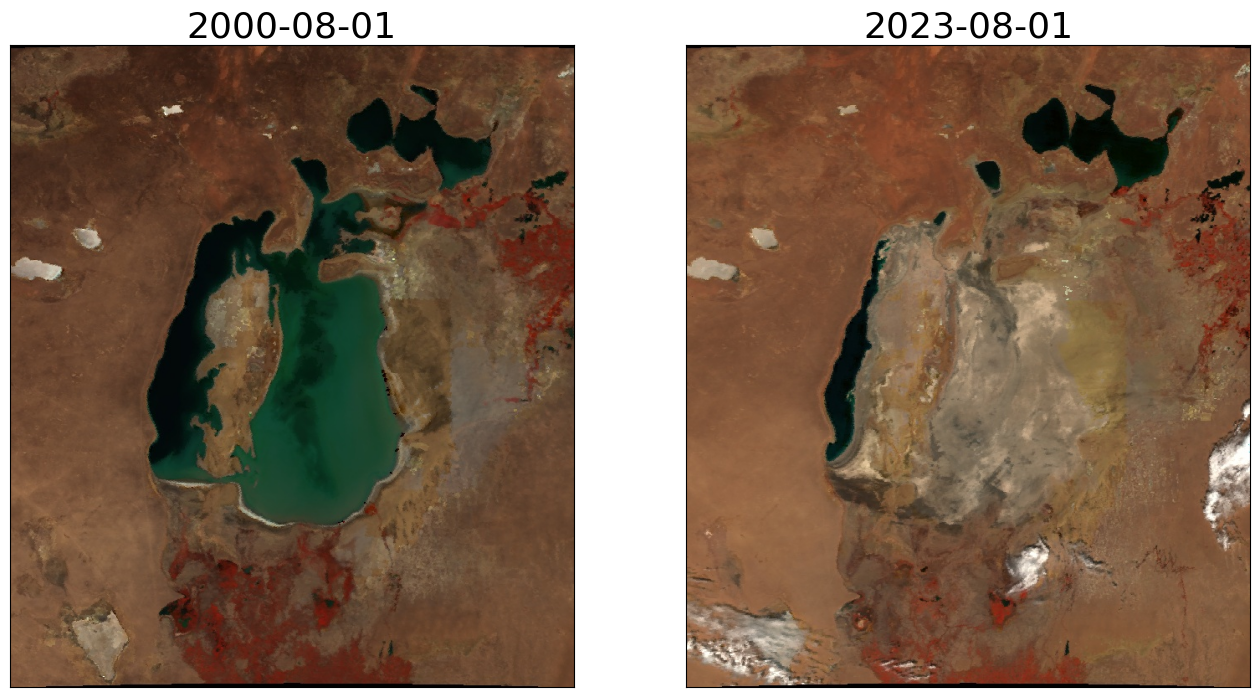

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_2000='/kaggle/input/remote-sensing-imagery-from-modis/MOD_01.jpg'
img_2023='/kaggle/input/remote-sensing-imagery-from-modis/MOD_24.jpg'


def img_show(img, img2):
    fig, ax=plt.subplots(ncols=2, figsize=(16,9))
    ax[0].imshow(img)
    ax[1].imshow(img2)
    for i in range(2):
        ax[i].set_facecolor('black')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    ax[0].set_title('2000-08-01', fontsize=26)
    ax[1].set_title('2023-08-01', fontsize=26)
    plt.show

img=mpimg.imread(img_2000)
img2=mpimg.imread(img_2023)

img_show(img, img2)

# Zoom in Images

Some area covered by the images is quite large, so we zoom in a little bit.

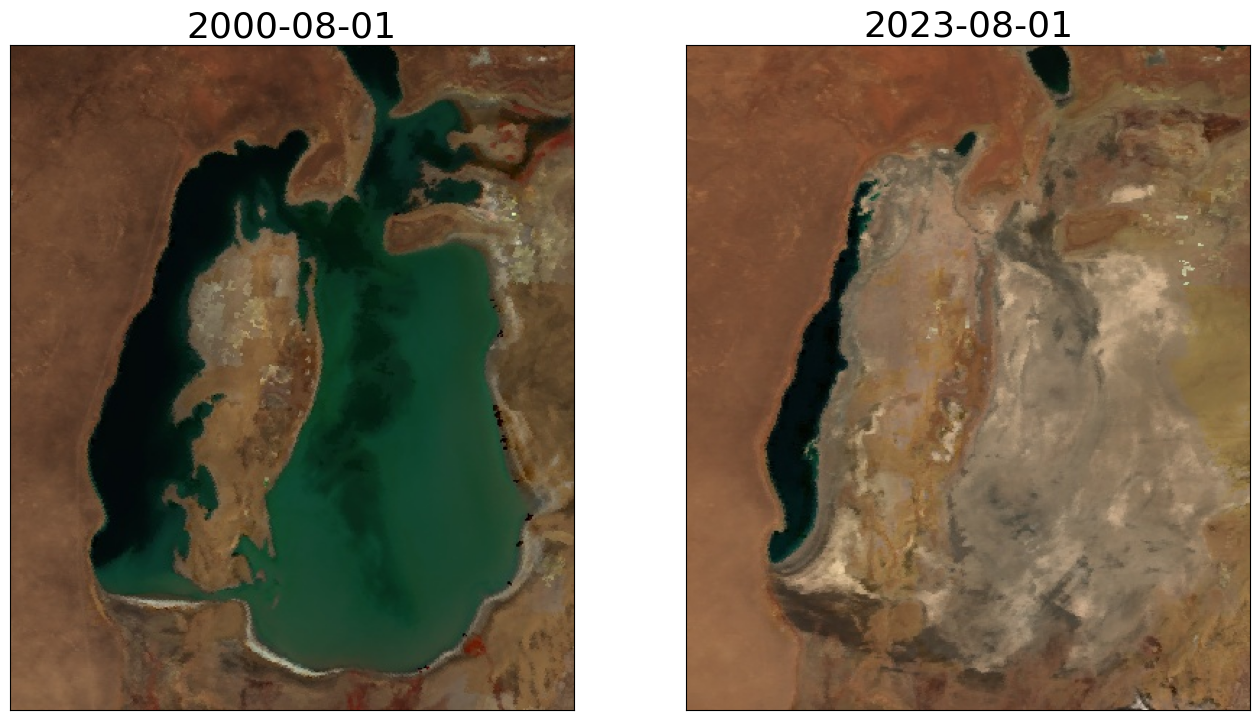

In [8]:
img=img[140:600, 110:500,:]
img2=img2[140:600, 110:500,:]

img_show(img, img2)

# Converting Images to pandas Dataframes

We convert images to pandas dataframes(one column for each image channel).

In [10]:
import pandas as pd

df= pd.DataFrame({'R': img[:,:,0].flatten(), 'G': img[:,:,1].flatten(), 'B':img[:,:,2].flatten()})
df2= pd.DataFrame({'R': img2[:,:,0].flatten(), 'G': img2[:,:,1].flatten(), 'B':img2[:,:,2].flatten()})

# k-Means Functions

In [12]:
def kmeans(data, K, kind):
    L=list()
    new_centroids=data.sample(K).values
    
    data=distance(data.copy(), new_centroids, kind)
    old_centroids=new_centroids.copy()
    new_centroids=np.array([data[data.Class==Class][['R','G','B']].mean().values for Class in data.loc[:,'C1':f'C{k}'].columns])
    i=1
    print(f'Iteration: {i}\tDistance: {abs(new_centroids.mean()-old_centroids.mean())}')
    while abs(new_centroids.mean()-old_centroids.mean())>0.001:
        L.append(abs(new_centroids.mean()-old_centroids.mean()))
        data=distance(data, new_centroids, kind)
        old_centroids=new_centroids.copy()
        new_centroids=np.array([data[data.Class==Class][['R','G','B']].mean().values for Class in data.loc[:,'C1':f'C{K}'].columns])
        i+=1
        print(f'Iteration: {i}\tDistance: {abs(new_centroids.mean()-old_centroids.mean())}')
    print(f'k-Means has ended with {i} iterations')
    return data, L

In [13]:
def distance(data, centroids, kind):
    """
    here kind can be Euclidean, manhattan, chebyshev
    """
    cols=list()
    for i in range(1, k+1):
        if kind=='euclidean':
            data[f'C{i}']=((centroids[i-1][0]-data.R)**2+(centroids[i-1][1]-data.G)**2+(centroids[i-1][2]-data.B)**2)**0.5
        elif kind=='manhattan':
            data[f'C{i}']=abs(centroids[i-1][0]-data.R)+abs(centroids[i-1][1]-data.G)+abs(centroids[i-1][2]-data.B)
        elif kind=='chebyshev':
            merged=pd.concat([centroids[i-1][0]-data.R, centroids[i-1][1]-data.G, centroids[i-1][2]-data.B], axis=1)
            data[f'C{i}']=merged.max(axis=1)
        cols.append(f'C{i}')
    data['Class']=data[cols].abs().idxmin(axis=1) # assigning clusters to points
    return data # returning the dataframe with k cluster olumns and one Class column with the final cluster

# Acknowledge

* https://towardsdatascience.com/semantic-segmentation-of-remote-sensing-imagery-using-k-means-e4c165d9218e